In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas
import numpy
import retl
import os
import pathlib
import matplotlib.pyplot as plt
import scipy.stats
import helper

## Calibration
### Load calibration data

In [2]:
dp_run = pathlib.Path('8X4PF4')
dp_results = pathlib.Path(f'{dp_run.name}_Results')
dp_results.mkdir(exist_ok=True)

In [3]:
df_standards = retl.parse(pathlib.Path(dp_run, 'Cutinase_Standard.xml'))['Label1_Copy1'].value

# concentrations of triplicates, ordered Fortran style:
standard_concentrations = numpy.array([
    0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1,
    1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2,
    2.2, 2.3, 2.4, 2.5, 2.6, 0.0001, 0.0001, 0.0001,
])
# numpy magic to expand it into the same shape as the wells:
standard_concentrations = numpy.repeat(
    standard_concentrations.reshape(3, 8).flatten('F')[None, :],
    repeats=3
).reshape(8, 3 * 3)
standard_concentrations

# the corresponding well IDs:
standard_wells = numpy.array([
    f'{r}{c:02d}'
    for r in 'ABCDEFGH'
    for c in range(1, 13)
]).reshape(8, 12)[:, 3:]

# compile into a nice DataFrame
df_calibration = pandas.DataFrame(
    columns=['concentration', 'absorbance'],
    index=standard_wells.flatten(),
)
df_calibration['concentration'] = standard_concentrations.flatten()
df_calibration['absorbance'] = df_standards.loc[1, df_calibration.index]
df_calibration.sort_values('concentration', inplace=True)
df_calibration

concentration  absorbance
H12         0.0001      0.4042
H10         0.0001      0.4141
G12         0.0001      0.4524
G11         0.0001      0.4429
G10         0.0001      0.4636
..             ...         ...
D11         2.5000         NaN
D10         2.5000         NaN
E12         2.6000         NaN
E10         2.6000         NaN
E11         2.6000         NaN

[72 rows x 2 columns]

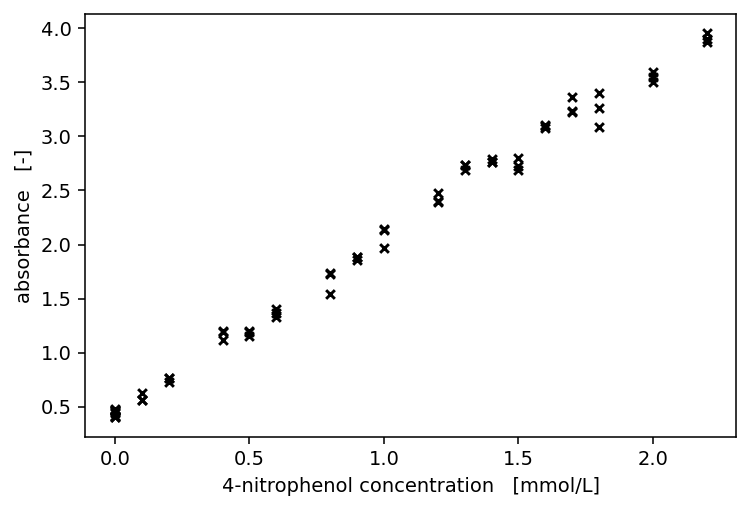

In [4]:
fig, ax = plt.subplots(dpi=140)
df_calibration.plot(kind='scatter', x='concentration', y='absorbance', ax=ax, marker='x', color='black')
ax.set_xlabel('4-nitrophenol concentration   [mmol/L]')
ax.set_ylabel('absorbance   [-]')
plt.show()

### Fit error model

In [5]:
import calibr8

class NitrophenolAbsorbanceModel(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key='4NP_concentration',
            dependent_key='absorbance',
            mu_degree=1, scale_degree=1
        )
        
em = NitrophenolAbsorbanceModel()
em.theta_names

('mu_0', 'mu_1', 'scale_0', 'scale_1', 'df')

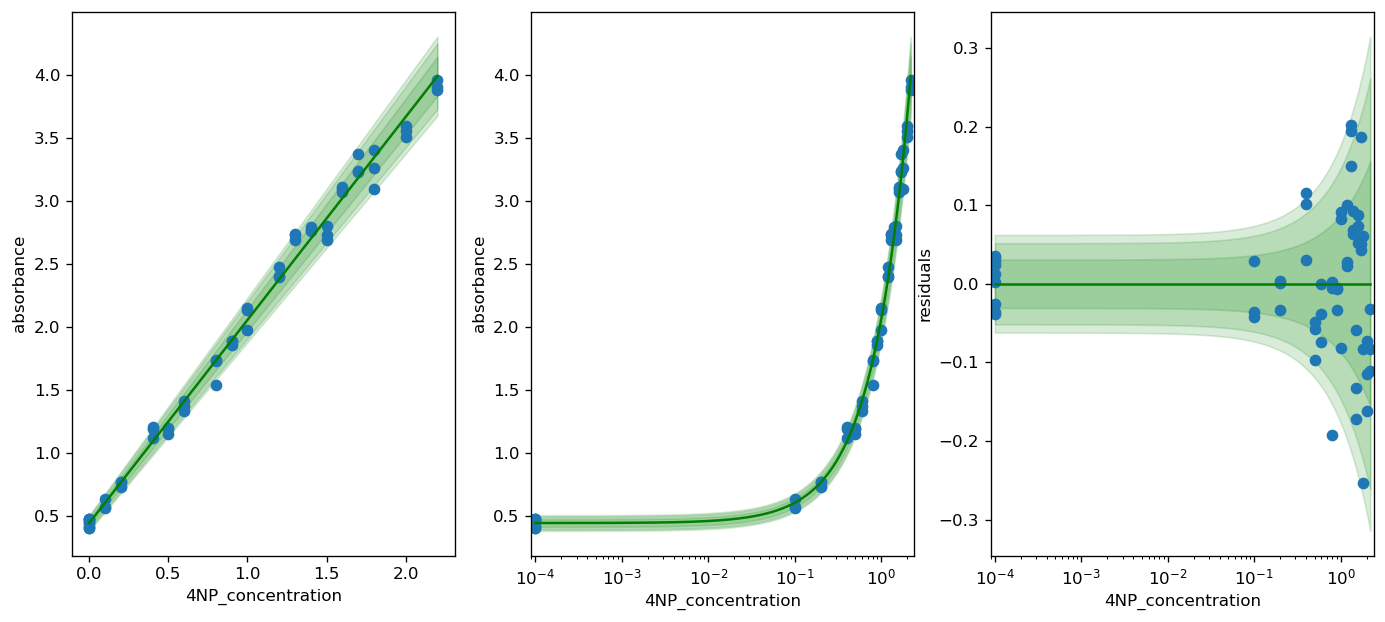

In [6]:
theta_fit, _ = calibr8.fit_scipy(
    model=em,
    independent=df_calibration.dropna().concentration.values,
    dependent=df_calibration.dropna().absorbance.values,
    theta_guess=[0.5, 2, 0.1, 0.1, 30],
    theta_bounds=[
        (0.01, 50)
    ] * len(em.theta_names)
)
fig, axs = calibr8.plot_model(em)
plt.show()

# Data evaluation

In [7]:
samples = retl.parse(pathlib.Path(dp_run, 'Cutinase_Sample.xml'))
df_samples = samples['Label1_Copy1'].value
# Time in minutes and not in hours
df_time = samples['Label1_Copy1'].time * 60

def get_at(i):
    absorbance = df_samples.loc[i].values.reshape(8, 12)
    concentration = em.predict_independent(absorbance.flatten()).reshape(absorbance.shape)
    return absorbance, concentration

### Visual inspection

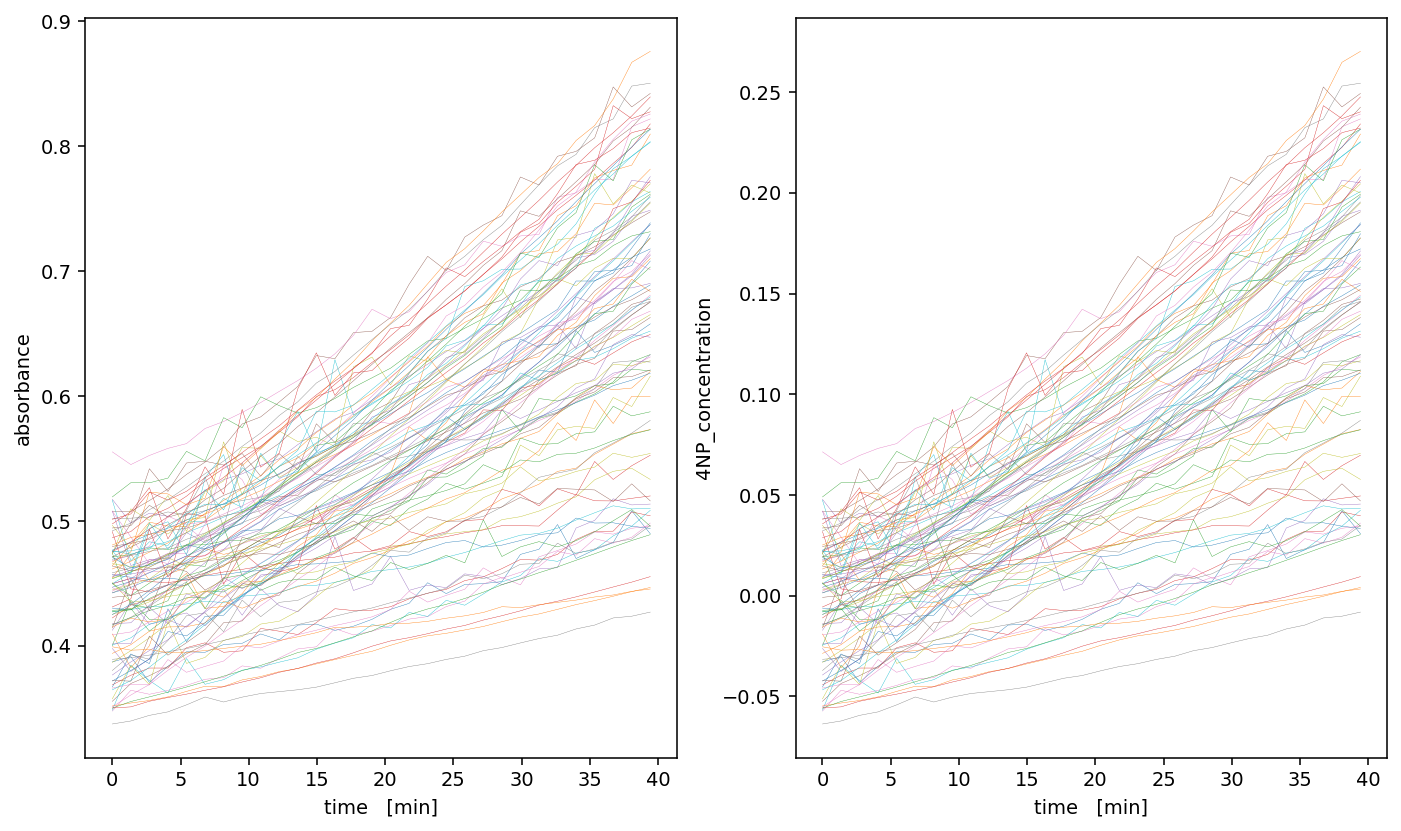

In [8]:
fig, (left, right) = plt.subplots(dpi=140, ncols=2, figsize=(12, 7))
for well in df_samples.columns:
    t = df_time[well]
    y = df_samples[well]
    left.plot(
        t,
        y,
        linewidth=0.2
    )
    right.plot(
        t,
        em.predict_independent(y),
        linewidth=0.2
    )
left.set_ylabel('absorbance')
right.set_ylabel(em.independent_key)
left.set_xlabel('time   [min]')
right.set_xlabel('time   [min]')
plt.show()

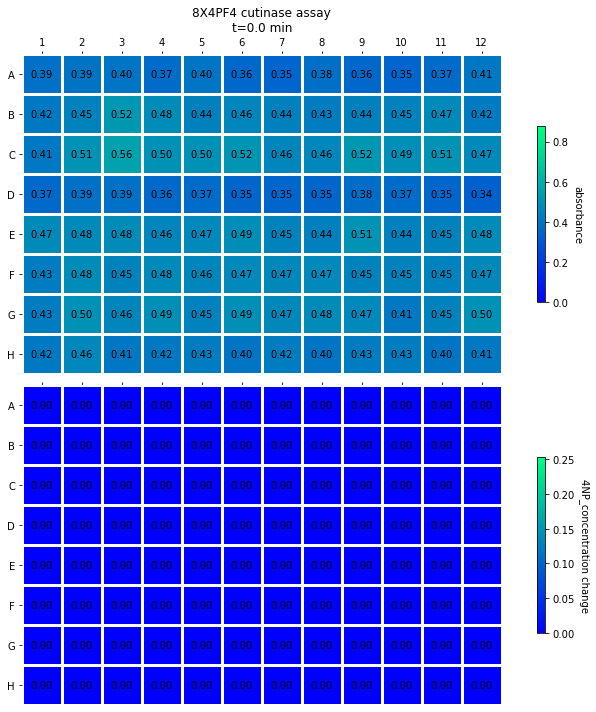

In [9]:
_, c_first = get_at(df_samples.index[0])
_, c_last = get_at(df_samples.index[-1])
max_absorbance = df_samples.values.max()
max_change = (c_last - c_first).max()

for i in df_samples.index:
    absorbance, concentration = get_at(i)
    
    fig, (up, down) = plt.subplots(nrows=2, figsize=(10, 10))
    
    # plot absorbances to the top    
    im, cbar = helper.heatmap(
        absorbance,
        row_labels='ABCDEFGH',
        col_labels=[1,2,3,4,5,6,7,8,9,10,11,12],
        ax=up,
        cmap='winter',
        cbarlabel=em.dependent_key,
        cbar_kw = dict(shrink = 0.55),
        vmin=0, vmax=max_absorbance
    )
    texts = helper.annotate_heatmap(
        im,
        threshold=1,
        valfmt='{x:.2f}'
    )
    
    # and concentration CHANGE in the bottom
    concentration_change = concentration - c_first
    im, cbar = helper.heatmap(
        concentration_change,
        row_labels='ABCDEFGH',
        col_labels=[None]*12,
        ax=down,
        cmap='winter',
        cbarlabel=em.independent_key + ' change',
        cbar_kw = dict(shrink = 0.55),
        vmin=0, vmax=max_change
    )
    texts = helper.annotate_heatmap(
        im,
        threshold=1,
        valfmt='{x:.2f}'
    )
    
    t = df_time.loc[i].min()
    up.set_title(f'{dp_run.name} cutinase assay\nt={t:.1f} min')
    fig.tight_layout()
    fig.savefig(pathlib.Path(dp_results, f'cutinase_cycle_{i:03d}.png'))
    if i == 1:
        plt.show()
    plt.close()

In [10]:
import imageio

fp_gif = pathlib.Path(dp_results, 'cutinase.gif')
with imageio.get_writer(fp_gif, fps=3) as writer:
    # iterate all frames, but append the last frame 5x extra for a nice "freeze" effect
    for i in list(df_samples.index) + [df_samples.index[-1]] * 10:
        img = imageio.imread(pathlib.Path(dp_results, f'cutinase_cycle_{i:03d}.png'))
        writer.append_data(img)

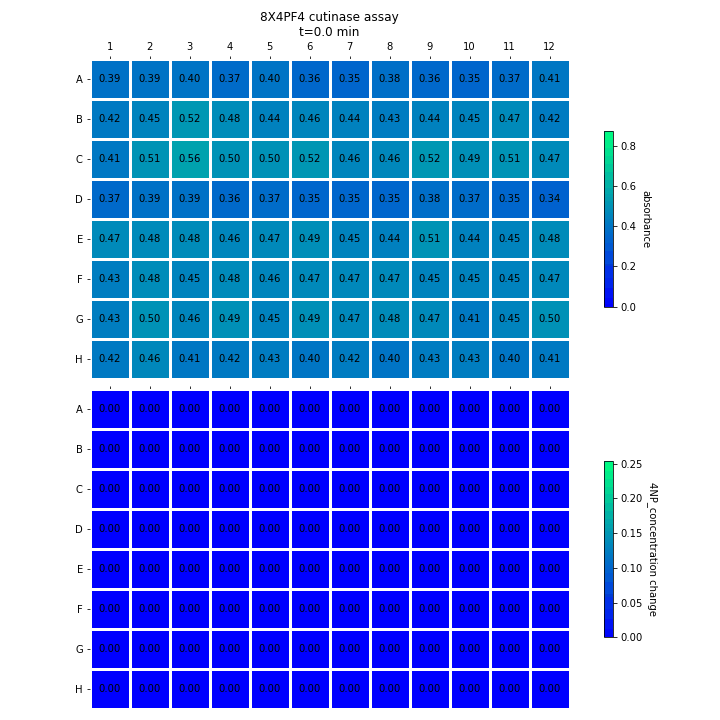

In [11]:
import IPython
IPython.display.Image(fp_gif)

### Fitting $v_{max}$
With a multilevel Bayesian linear regression model, just because we can.

In [12]:
import pymc3
import arviz
import theano.tensor as tt

In [13]:
df_events = pandas.read_excel(
    pathlib.Path(dp_run, 'eventlog.xlsx'),
    sheet_name='samplings',
    index_col=0
).set_index('well')
df_events['assay_wells'] = [
    f'{swell},{swell[0]}{int(swell[1:])+6:02d}'
    for swell in df_events.supernatant_well
]
assert 'A01,A07' in set(df_events.assay_wells)
df_events.sort_index(inplace=True)
df_events.head()

timestamp       time  cycle  volume supernatant_well  \
well                                                                        
A01   2020-07-21T08:10:04.721Z  13.076466     61    -950              H01   
A02   2020-07-21T07:05:04.299Z  11.993016     56    -950              G01   
A03   2020-07-21T08:10:04.786Z  13.076485     61    -950              F01   
A04   2020-07-21T08:10:04.841Z  13.076500     61    -950              E01   
A05   2020-07-21T06:26:17.384Z  11.346651     53    -950              D01   

     assay_wells  
well              
A01      H01,H07  
A02      G01,G07  
A03      F01,F07  
A04      E01,E07  
A05      D01,D07

In [14]:
n_wells = len(df_events)
n_assay_wells = 2
n_time = len(df_samples)

# reshape data into two 3D arrays:
t_obs = numpy.empty((n_wells, n_assay_wells, n_time))
y_obs = numpy.empty((n_wells, n_assay_wells, n_time))
for w, well in enumerate(df_events.index):
    assay_wells = df_events.loc[well, 'assay_wells'].split(',')
    for r, replicate_well in enumerate(assay_wells):
        t_obs[w, r, :] = df_time[replicate_well].values
        y_obs[w, r, :] = df_samples[replicate_well].values

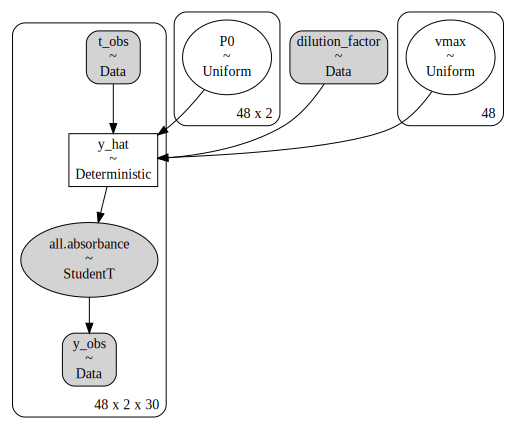

In [23]:
coords = {
    'well': df_events.index,
    'replicate': numpy.arange(1, n_assay_wells + 1),
    'cycle': df_time.index,
}
with pymc3.Model(coords=coords) as pmodel:
    # data
    t_y_obs = pymc3.Data('y_obs', y_obs, dims=('well', 'replicate', 'cycle'))
    t_t_obs = pymc3.Data('t_obs', t_obs, dims=('well', 'replicate', 'cycle'))
    
    # priors
    t_P0 = pymc3.Uniform('P0', -0.5, 1, dims=('well', 'replicate'))
    
    # Activity (vmax) should be reported as specific enzyme activity in the supernatant [µmol/mL/min].
    # The supernatant is diluted 500x into the assay.
    # The reaction product (4-nitrophenol) is measured in [mmol/L] = [µmol/mL] via the error model.
    # The vmax should therefore be divided by the dilution factor to model the specific activity in the assay:
    dilution_factor = pymc3.Data('dilution_factor', 500)
    t_vmax = pymc3.Uniform('vmax', 0, 10, dims=('well',)) / dilution_factor
    
    # prediction
    t_y_hat = pymc3.Deterministic(
        'y_hat',
        t_P0[:, :, None] + t_vmax[:, None, None] * t_t_obs,
        dims=('well', 'replicate', 'cycle')
    )
    
    # likelihood
    L = em.loglikelihood(
        y=t_y_obs,
        x=t_y_hat,
        replicate_id='all',
        dependent_key=em.dependent_key
    )
pymc3.model_to_graphviz(pmodel)

In [24]:
with pmodel:
    theta_map = pymc3.find_MAP()

In [25]:
with pmodel:
    idata = pymc3.sample(
        return_inferencedata=True,
    )

idata.to_netcdf(pathlib.Path(dp_results, 'trace.nc'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [vmax, P0]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 908 seconds.


WindowsPath('8X4PF4_Results/trace.nc')

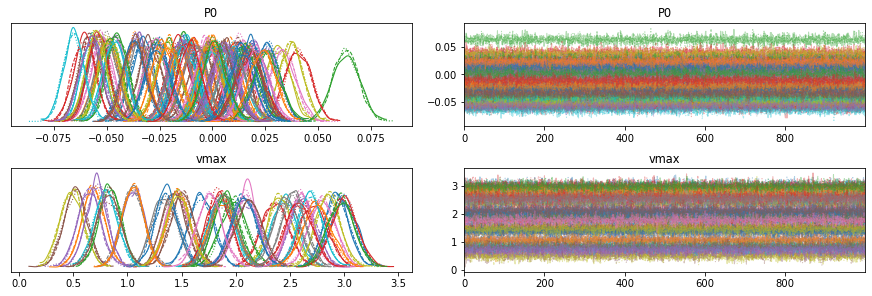

In [26]:
arviz.plot_trace(idata, compact=True, var_names=['P0', 'vmax']);

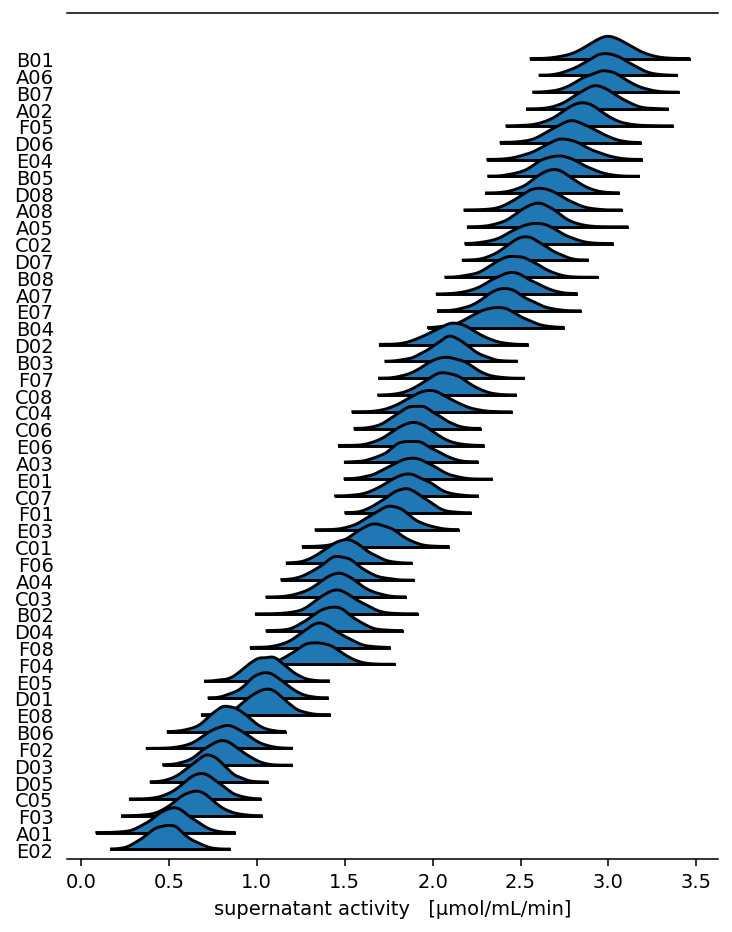

In [27]:
order = numpy.argsort(idata.posterior.vmax.mean(dim=('chain', 'draw')).values)
well_order = list(idata.posterior.well.values[list(order)[::-1]])

fig, ax = plt.subplots(dpi=140, figsize=(6,8))
arviz.plot_forest(
    idata,
    kind='ridgeplot',
    combined=True,
    var_names=['vmax'],
    coords=dict(well=well_order),
    ax=ax
)
ax.set_yticklabels(well_order)
ax.set_xlabel('supernatant activity   [µmol/mL/min]')
plt.show()

In [28]:
import ipywidgets
def plot_fit(well:str):
    fig, ax = plt.subplots(dpi=140)
    for r, color, palette in [(1, 'green', 'Greens'), (2, 'blue', 'Blues')]:
        pymc3.gp.util.plot_gp_dist(
            ax=ax,
            x=idata.constant_data.t_obs.sel(well=well, replicate=r).values,
            samples=idata.posterior.y_hat.stack(sample=('chain', 'draw')).sel(well=well, replicate=r).T,
            palette=palette
        )
        ax.scatter(
            idata.constant_data.t_obs.sel(well=well, replicate=r).values,
            em.predict_independent(idata.constant_data.y_obs.sel(well=well, replicate=r).values),
            color=color
        )
    ax.set_ylabel('product concentration   [mmol/L]')
    ax.set_xlabel('time   [min]')
    plt.show()

ipywidgets.interact(
    plot_fit,
    well=idata.posterior.well.values
);

interactive(children=(Dropdown(description='well', options=('A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', '…

### Export summary

In [29]:
df_results = pandas.DataFrame(
    index=idata.posterior.well
)
df_results['vmax_mean'] = idata.posterior.vmax.mean(dim=('chain', 'draw'))
hdi = arviz.hdi(idata.posterior.vmax)
df_results['vmax_hdi_3%'] = hdi.sel(hdi='lower').vmax
df_results['vmax_hdi_97%'] = hdi.sel(hdi='higher').vmax
df_results

vmax_mean  vmax_hdi_3%  vmax_hdi_97%
well                                      
A01    2.988552     2.768288      3.202110
A02    0.683380     0.476446      0.861842
A03    1.888099     1.666430      2.088952
A04    2.360913     2.121860      2.588482
A05    1.055207     0.870872      1.244021
A06    0.519094     0.330444      0.714802
A07    1.460087     1.275194      1.679600
A08    1.052525     0.857281      1.242399
B01    0.487214     0.294465      0.684625
B02    2.447150     2.224734      2.688828
B03    1.680869     1.463873      1.880784
B04    1.473384     1.262674      1.681375
B05    0.837064     0.645933      1.018215
B06    2.720220     2.501387      2.971466
B07    0.645988     0.447964      0.840593
B08    1.429444     1.241862      1.630024
C01    2.099640     1.908627      2.322792
C02    1.343934     1.132823      1.543459
C03    2.415732     2.184199      2.630154
C04    1.858857     1.629694      2.070452
C05    2.931058     2.724509      3.143514
C06    1.879297     1.646577      2.112307
C07    1.983174     1.758981      2.217964
C08    1.841253     1.642212      2.031208
D01    2.619175     2.406150      2.833277
D02    1.506487     1.301054      1.707517
D03    2.798224     2.582065      3.023626
D04    2.468386     2.254472      2.695761
D05    2.851785     2.627175      3.058616
D06    0.801100     0.593589      0.991278
D07    1.364930     1.169539      1.580918
D08    1.050945     0.861851      1.235984
E01    1.910716     1.719859      2.128629
E02    3.000648     2.785304      3.240359
E03    2.083704     1.877362      2.310603
E04    0.824335     0.609360      1.033971
E05    2.597116     2.391920      2.805145
E06    1.884222     1.658376      2.105528
E07    1.463781     1.239757      1.665336
E08    2.688844     2.473982      2.894391
F01    2.073978     1.853997      2.276927
F02    2.750676     2.513230      2.996067
F03    2.971312     2.748118      3.195245
F04    2.583557     2.356100      2.817433
F05    0.716201     0.523858      0.895795
F06    2.118945     1.886585      2.340086
F07    1.760788     1.554484      1.982133
F08    2.532691     2.329314      2.742631

In [30]:
df_results.to_excel(pathlib.Path(dp_results, 'activity.xlsx'))